In [28]:
import numpy as np
import pandas as pd
from lstm_functions import *
from lost_functions import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
from sklearn.decomposition import PCA


In [29]:
xls = pd.ExcelFile('data/data_for_testing.xlsx')
all_data = {}
# This is too much data to load into memory at once
# for sheet in xls.sheet_names:
#     all_data[sheet] = pd.read_excel(xls, sheet_name=sheet)
for sheet in ["XOM", "SHW", "UPS", "DUK", "UNH", "JPM", "AMZN", "AAPL", "META", "AMT"]:
    data = pd.read_excel(xls, sheet_name=sheet).set_index('Date')
    # Resample to monthly data as a simple way to reduce the number of data points
    # Daily data is too much and take too long to train
    # monthly_data = data.resample('M').last().reset_index()
    original_data = data.reset_index()
    all_data[sheet] = original_data

In [30]:
all_data['XOM'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Sector,Ticker
0,1962-01-02,0.0,1.589844,1.578125,1.578125,0.096660,902400,Energy,XOM
1,1962-01-03,0.0,1.601563,1.578125,1.601563,0.098095,1200000,Energy,XOM
2,1962-01-04,0.0,1.613281,1.597656,1.605469,0.098335,1088000,Energy,XOM
3,1962-01-05,0.0,1.613281,1.566406,1.570313,0.096181,1222400,Energy,XOM
4,1962-01-08,0.0,1.582031,1.546875,1.566406,0.095942,1388800,Energy,XOM


In [31]:
dfs = []  # List to hold individual DataFrames for each stock's transformed data

# Loop over each stock in the all_data dictionary
for stock, data in all_data.items():
    
    # Drop non-numeric columns, like 'Date' and 'Sector'
    numeric_data = data.drop(columns=['Date', 'Sector', "Ticker"])
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_data)
    
    # Apply PCA
    pca = PCA(n_components=1)
    transformed_data = pca.fit_transform(scaled_data)
    
    # Create a new DataFrame for the transformed data and set its column name to the stock
    df_stock = pd.DataFrame(transformed_data, columns=[stock], index=data['Date'])
    dfs.append(df_stock)

# Concatenate all individual DataFrames to create the all_stock DataFrame
all_stock = pd.concat(dfs, axis=1)

all_stock = all_stock.dropna()
all_stock

,XOM,SHW,UPS,DUK,UNH,JPM,AMZN,AAPL,META,AMT
Date,,,,,,,,,,
2012-05-18,3.478038,-0.207014,-1.067590,1.640086,-0.460454,-0.045039,-0.967054,-0.175595,6.954546,-0.631626
2012-05-21,3.205822,-0.181620,-1.059017,1.539188,-0.418354,0.033372,-0.930354,-0.102414,3.996253,-0.604578
2012-05-22,3.229746,-0.165553,-1.045318,1.816959,-0.423939,-0.020945,-0.934165,-0.103473,3.564571,-0.640164
2012-05-23,3.323495,-0.151068,-1.060424,1.680701,-0.408617,-0.231510,-0.946742,-0.056809,3.348923,-0.619757
2012-05-24,3.259398,-0.116145,-1.022029,1.816028,-0.452707,-0.322557,-0.923368,-0.015167,3.146973,-0.595672
...,...,...,...,...,...,...,...,...,...,...
2023-09-08,5.985778,6.998766,3.854588,3.919958,7.011402,5.974646,4.818235,9.003848,-3.732795,2.809134
2023-09-11,5.966054,7.048274,3.837303,4.127691,7.004088,6.026697,4.962968,9.047471,-3.866347,2.776599
2023-09-12,6.278726,6.946335,3.573316,4.107700,6.968067,6.108960,4.988847,8.930482,-3.870835,2.737036


In [32]:
def evaluate_model(y_train, train_predictions, y_test, test_predictions, ticker, feature):
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

    print(f"\nEvaluation for {ticker} on {feature}:")
    print(f"Training MAE: {train_mae}, Testing MAE: {test_mae}")
    print(f"Training RMSE: {train_rmse}, Testing RMSE: {test_rmse}\n")
    return train_mae, test_mae, train_rmse, test_rmse

In [33]:
def plot_predictions(y_train, train_predictions, y_test, test_predictions, ticker, feature):
    plt.figure(figsize=(14,7))
    plt.plot(y_train, label="Actual Train Values", color='blue')
    plt.plot(train_predictions, label="Predicted Train Values", color='blue', linestyle='dashed')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label="Actual Test Values", color='red')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predictions, label="Predicted Test Values", color='red', linestyle='dashed')
    plt.title(f"{ticker} {feature} - Actual vs Predicted Values")
    plt.legend()
    plt.show()

In [34]:
final_importance_values = {}
final_predictions = {}
# 30 is not a good number of batches, but it's a start for testing
# 60 is a good number of batches, but it takes a long time to train
time_steps = 60
features = len(all_stock.columns)
features
batch_size_value = 4

In [35]:
data = all_stock.copy().dropna()
lstm_model = LstmBuilder(time_step=time_steps, loss="mean_squared_error", batch_size=batch_size_value)
model = lstm_model.create_stateful_model(features=features)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)
X, y = lstm_model.create_sequences(normalized_data)
X_train, X_test, y_train, y_test = lstm_model.split_stateful_data(X,y, 0.9)

Remaining:  1


In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2508, 60, 10), (280, 60, 10), (2508, 10), (280, 10))

In [37]:
model.fit(X_train, y_train, epochs=200, batch_size=batch_size_value, verbose=0)

# Extracting importance
dense_weights = model.layers[-1].get_weights()[0]

# Think about to use sum or mean and to use abs() or not
feature_weights = dense_weights.sum(axis=0)
print(feature_weights)

2023-10-18 22:25:31.540959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

3/3 [==============================] - 0s 33ms/step

Evaluation for XOM on XOM:
Training MAE: 0.2718475876575998, Testing MAE: 0.5061795942580555
Training RMSE: 0.34656571319446944, Testing RMSE: 0.5822715764652584



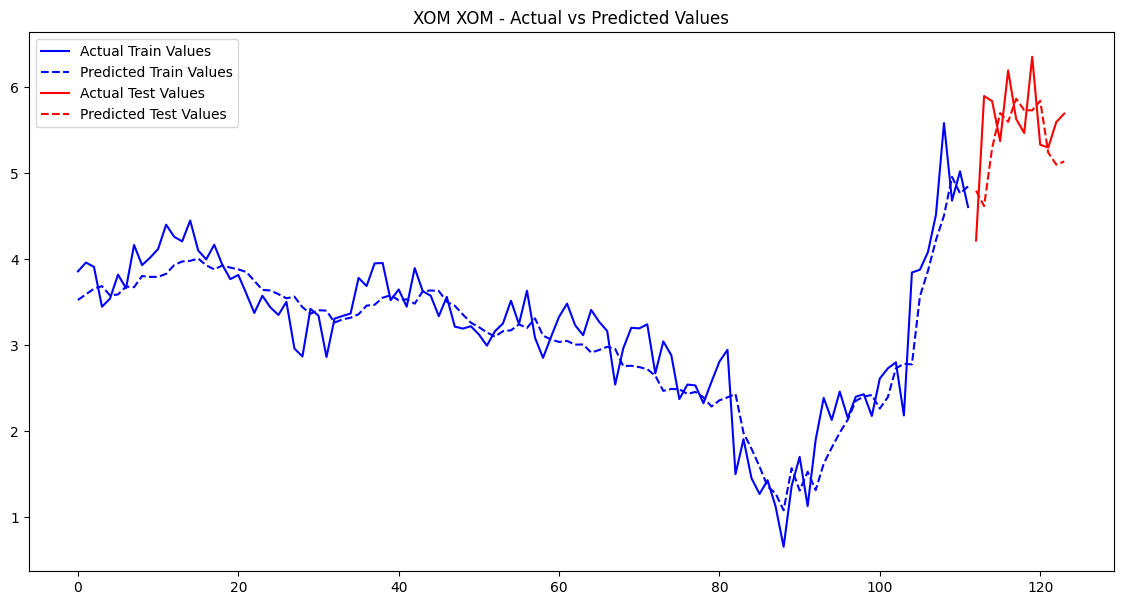


Evaluation for SHW on SHW:
Training MAE: 0.28574785045759116, Testing MAE: 0.6057186819823029
Training RMSE: 0.3849473439035387, Testing RMSE: 0.6823028618305983



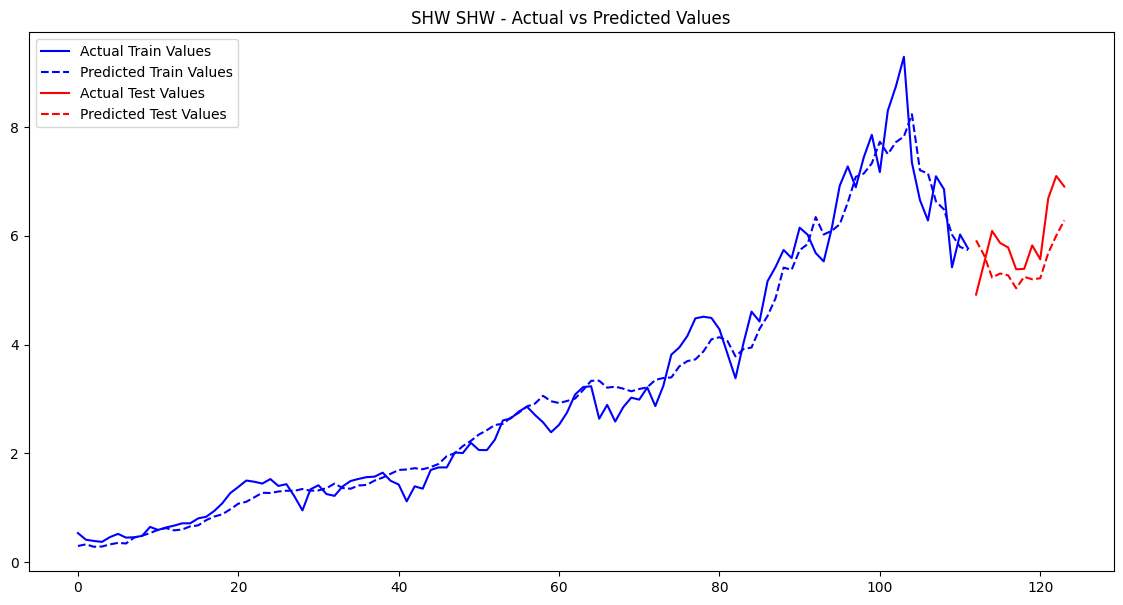


Evaluation for UPS on UPS:
Training MAE: 0.3518613399754362, Testing MAE: 0.7587532108383517
Training RMSE: 0.47052469002211583, Testing RMSE: 0.8625360968996797



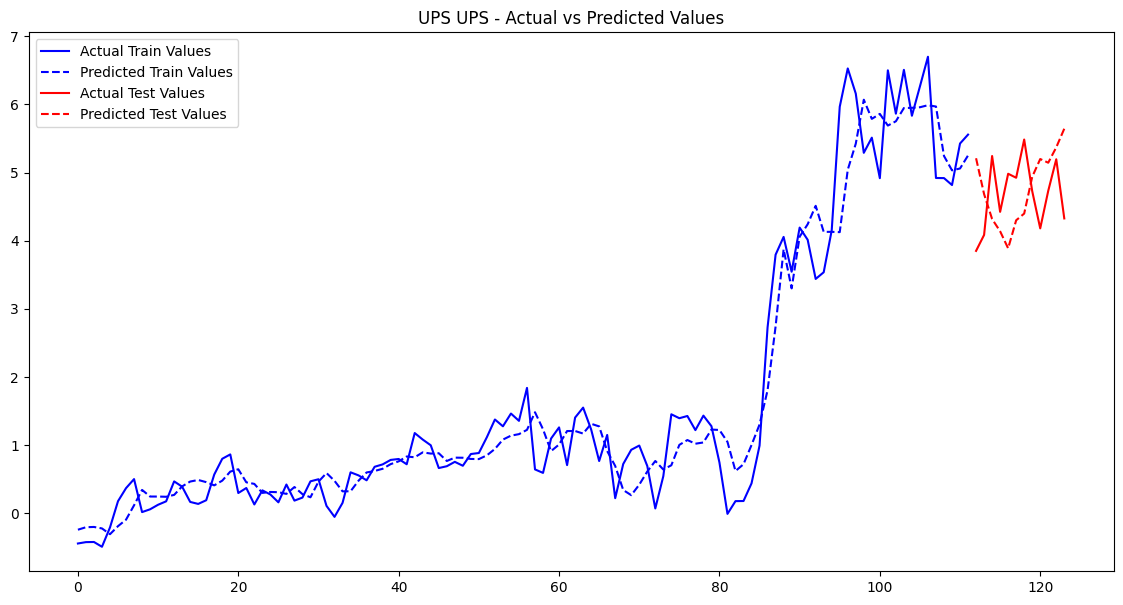


Evaluation for DUK on DUK:
Training MAE: 0.30997380195714264, Testing MAE: 0.7101878476132001
Training RMSE: 0.43760345334005113, Testing RMSE: 0.791769630888401



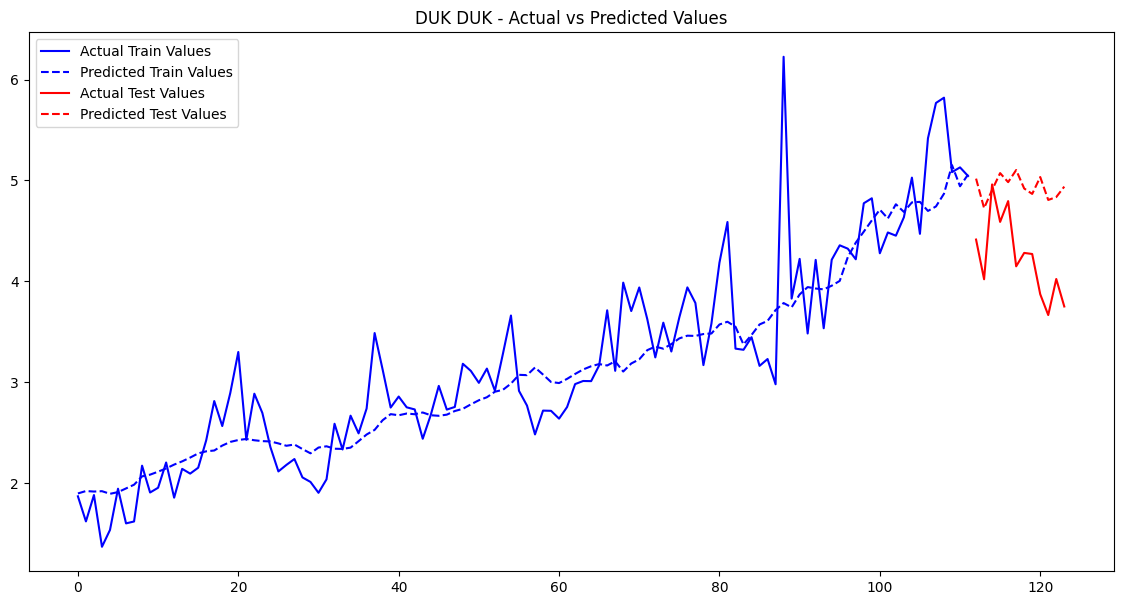


Evaluation for UNH on UNH:
Training MAE: 0.26704993485810086, Testing MAE: 0.7975338675252658
Training RMSE: 0.3451141116658234, Testing RMSE: 0.869475515576668



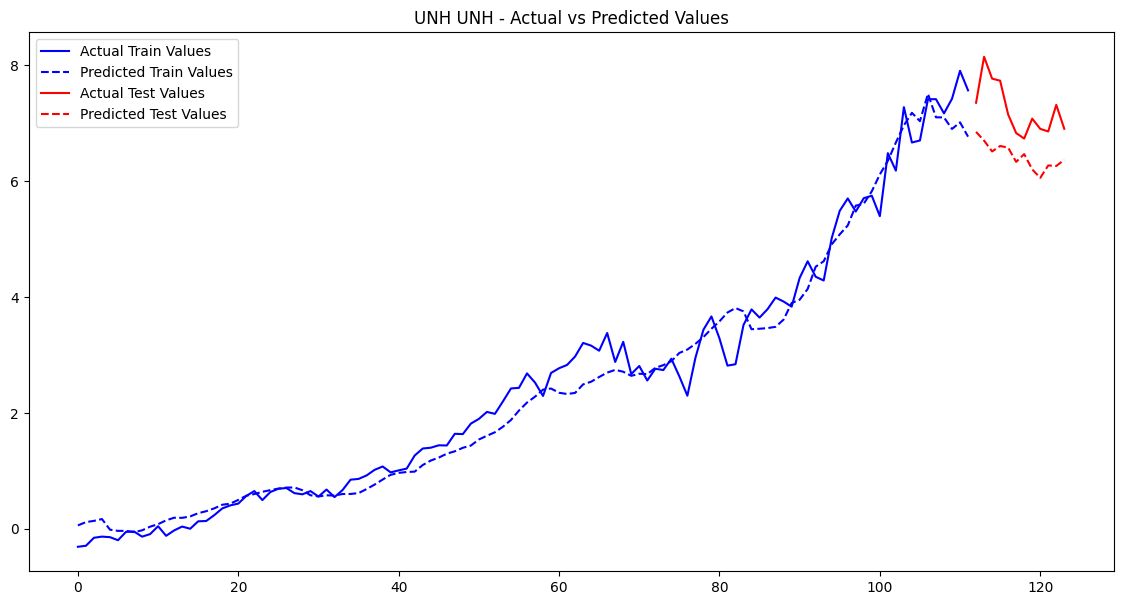


Evaluation for JPM on JPM:
Training MAE: 0.3318147614230852, Testing MAE: 1.6834929269245802
Training RMSE: 0.4420263479970722, Testing RMSE: 1.7893532535781385



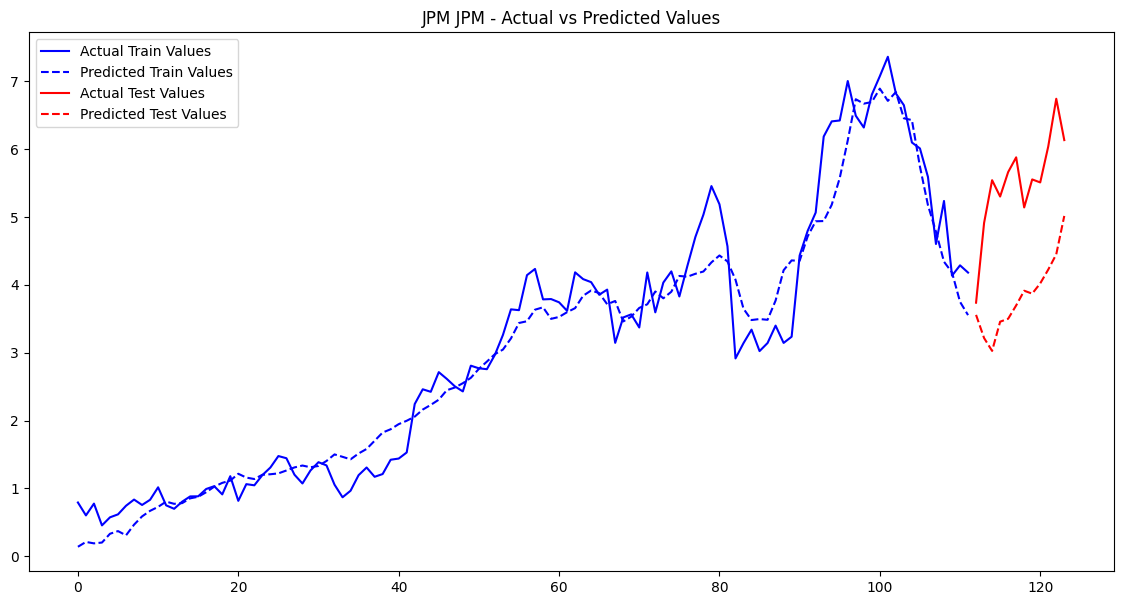


Evaluation for AMZN on AMZN:
Training MAE: 0.2762255647250031, Testing MAE: 0.9667071516978171
Training RMSE: 0.37025176439875684, Testing RMSE: 1.1514955658278567



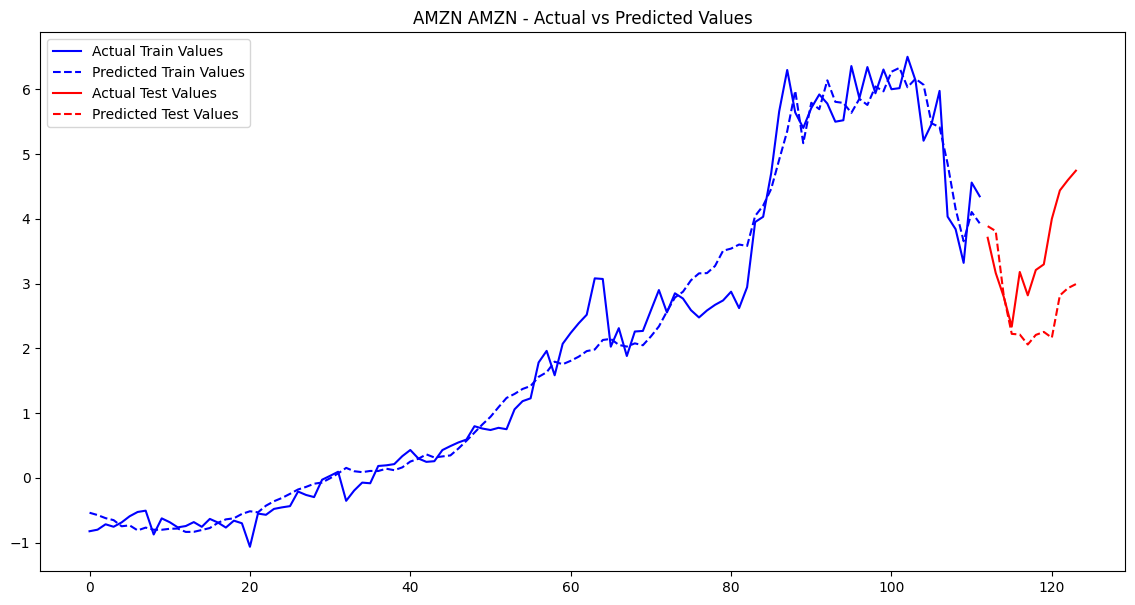


Evaluation for AAPL on AAPL:
Training MAE: 0.214772490072608, Testing MAE: 1.460641774354355
Training RMSE: 0.2988467753810672, Testing RMSE: 1.7378937742827254



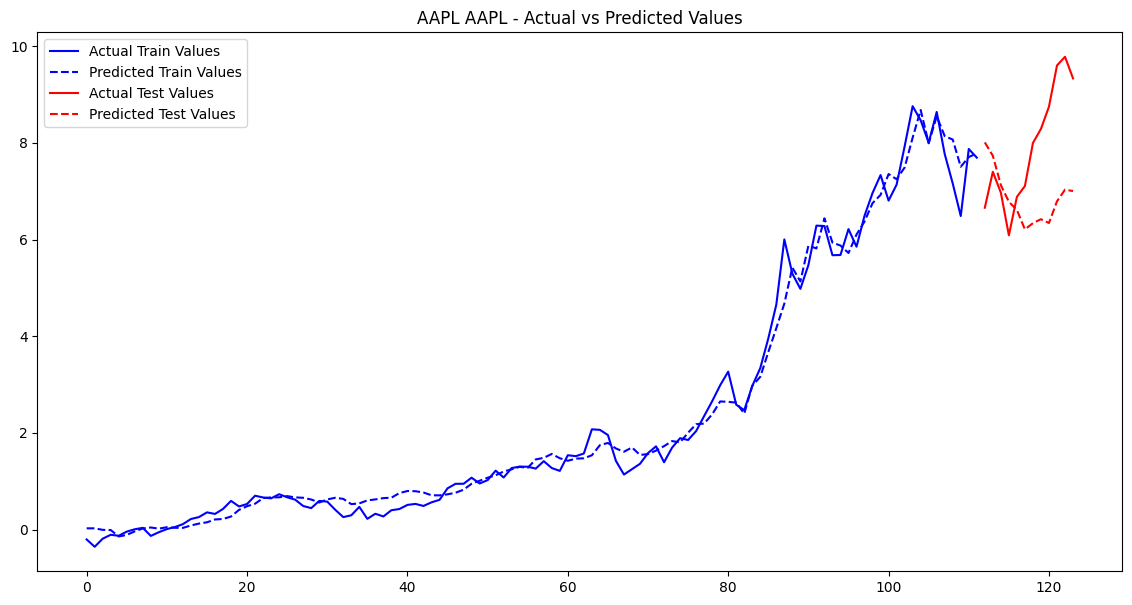


Evaluation for META on META:
Training MAE: 0.3504409256132291, Testing MAE: 1.5907173591791963
Training RMSE: 0.46021966806987114, Testing RMSE: 1.9214353358955307



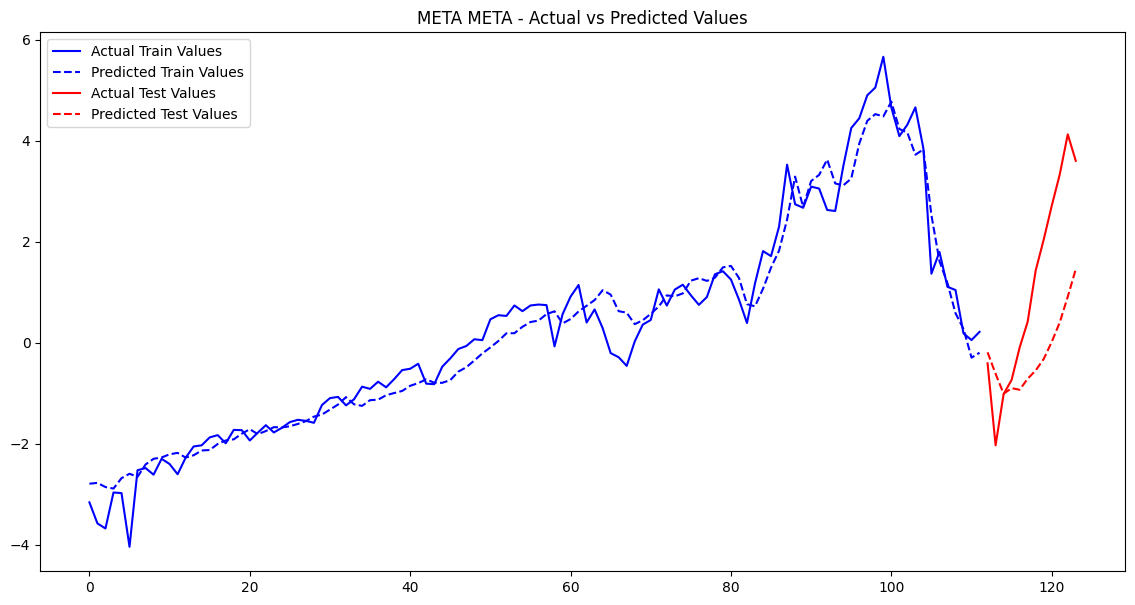


Evaluation for AMT on AMT:
Training MAE: 0.27190676789990437, Testing MAE: 0.40568671173251114
Training RMSE: 0.36104970037328404, Testing RMSE: 0.49781215084216496



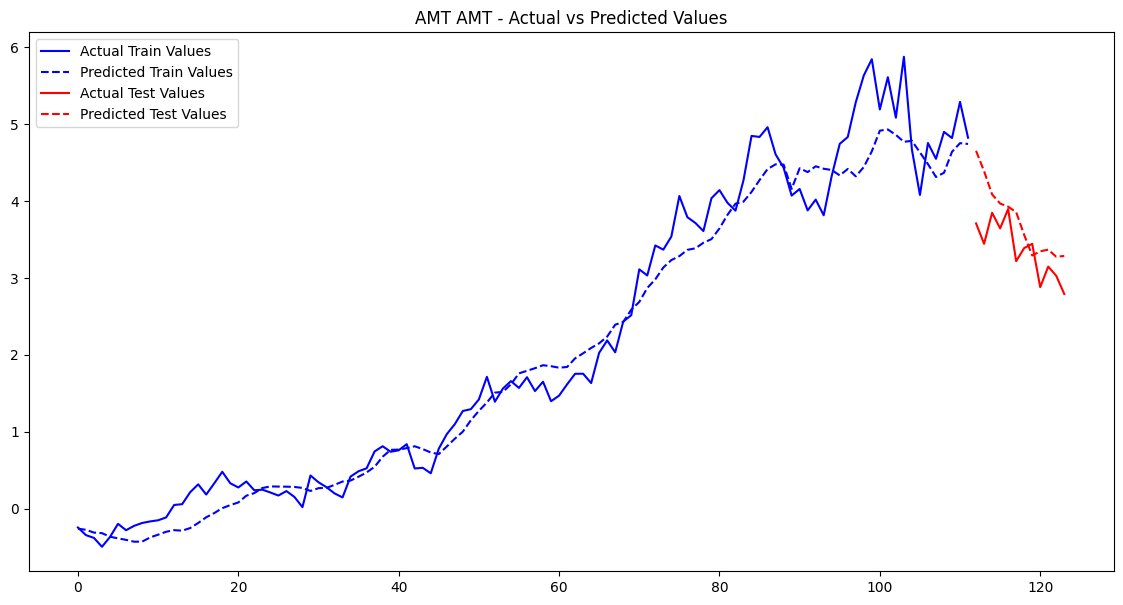

In [ ]:
# Predict for both training and testing data
train_predictions = scaler.inverse_transform(model.predict(X_train, batch_size=batch_size_value))
test_predictions = scaler.inverse_transform(model.predict(X_test, batch_size=batch_size_value))
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
features_list = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for feature_index, feature_name in enumerate(data.columns):
    # Extracting data for the specific feature
    y_train_feature = y_train[:, feature_index]
    y_test_feature = y_test[:, feature_index]
    train_predictions_feature = train_predictions[:, feature_index]
    test_predictions_feature = test_predictions[:, feature_index]

    # Evaluating the model for this feature
    evaluate_model(y_train_feature, train_predictions_feature, y_test_feature, test_predictions_feature, feature_name, feature_name)

    # Plotting the results for this feature
    plot_predictions(y_train_feature, train_predictions_feature, y_test_feature, test_predictions_feature, feature_name, feature_name)


In [ ]:
final_importance_values = dict(zip(data.columns, feature_weights))
final_importance_values

{'XOM': 0.8618879,
 'SHW': -0.7467822,
 'UPS': 2.5912335,
 'DUK': 0.53588486,
 'UNH': 1.4108318,
 'JPM': 0.4336225,
 'AMZN': 0.644185,
 'AAPL': 0.48265082,
 'META': 0.37773496,
 'AMT': 0.9021964}

In [ ]:
importance_values = np.array(list(final_importance_values.values()))
importance_values

array([ 0.8618879 , -0.7467822 ,  2.5912335 ,  0.53588486,  1.4108318 ,
        0.4336225 ,  0.644185  ,  0.48265082,  0.37773496,  0.9021964 ],
      dtype=float32)

# Run this if we want a arbitrage strategy
Each weight will be -1 to 1, the sum is 0

In [ ]:
# 1. Scale the values to [-1, 1]
arbitrage_scaled_importance = 2 * (importance_values - np.min(importance_values)) / (np.max(importance_values) - np.min(importance_values)) - 1

# 2. Ensure the sum is zero
arbitrage_normalized_importance = arbitrage_scaled_importance - np.mean(arbitrage_scaled_importance)

# Convert back to dictionary
arbitrage_ticker_to_importance = dict(zip(final_importance_values.keys(), arbitrage_normalized_importance))

print(arbitrage_ticker_to_importance)

{'XOM': 0.06743125, 'SHW': -0.89641684, 'UPS': 1.1035831, 'DUK': -0.12789616, 'UNH': 0.39633563, 'JPM': -0.18916753, 'AMZN': -0.06300726, 'AAPL': -0.15979174, 'META': -0.22265294, 'AMT': 0.091582455}


# Run this instead if we want a normal strategy
Each weight will be 0 to 1, the sum is 1

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))  # subtract max to avoid potential overflow
    return e_x / e_x.sum(axis=0)

# Convert the importance values to probabilities using softmax
probabilities = softmax(importance_values)

# Convert back to dictionary
normalized_ticker_to_importance = dict(zip(final_importance_values.keys(), probabilities))

print(normalized_ticker_to_importance)

{'XOM': 0.0764054, 'SHW': 0.015292819, 'UPS': 0.43069443, 'DUK': 0.05514964, 'UNH': 0.1322901, 'JPM': 0.049788695, 'AMZN': 0.06145778, 'AAPL': 0.052290574, 'META': 0.047082447, 'AMT': 0.07954809}


In [ ]:
def plot_importance(normalized_ticker_to_importance = normalized_ticker_to_importance, title='Normalized Importance Values'):
# Split the tickers and importance values based on positive and negative values
    long_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v > 0}
    short_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v <= 0}

    # Sort the positions for better visualization
    sorted_long = dict(sorted(long_positions.items(), key=lambda item: item[1], reverse=True))
    sorted_short = dict(sorted(short_positions.items(), key=lambda item: item[1]))

    # Create bar charts
    fig, ax = plt.subplots(figsize=(12, 7))

    # Positive cluster
    bars_long = ax.bar(sorted_long.keys(), sorted_long.values(), color='g', label='Long')

    # Negative cluster
    bars_short = ax.bar(sorted_short.keys(), sorted_short.values(), color='r', label='Short')

    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Annotate the bars
    for bar in bars_long:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=9)

    for bar in bars_short:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval - 0.02, round(yval, 3), ha='center', va='top', fontsize=9)

    ax.set_title(title)
    ax.set_ylabel('Importance Value')
    ax.set_xlabel('Ticker')
    ax.legend()

    plt.tight_layout()
    plt.show()


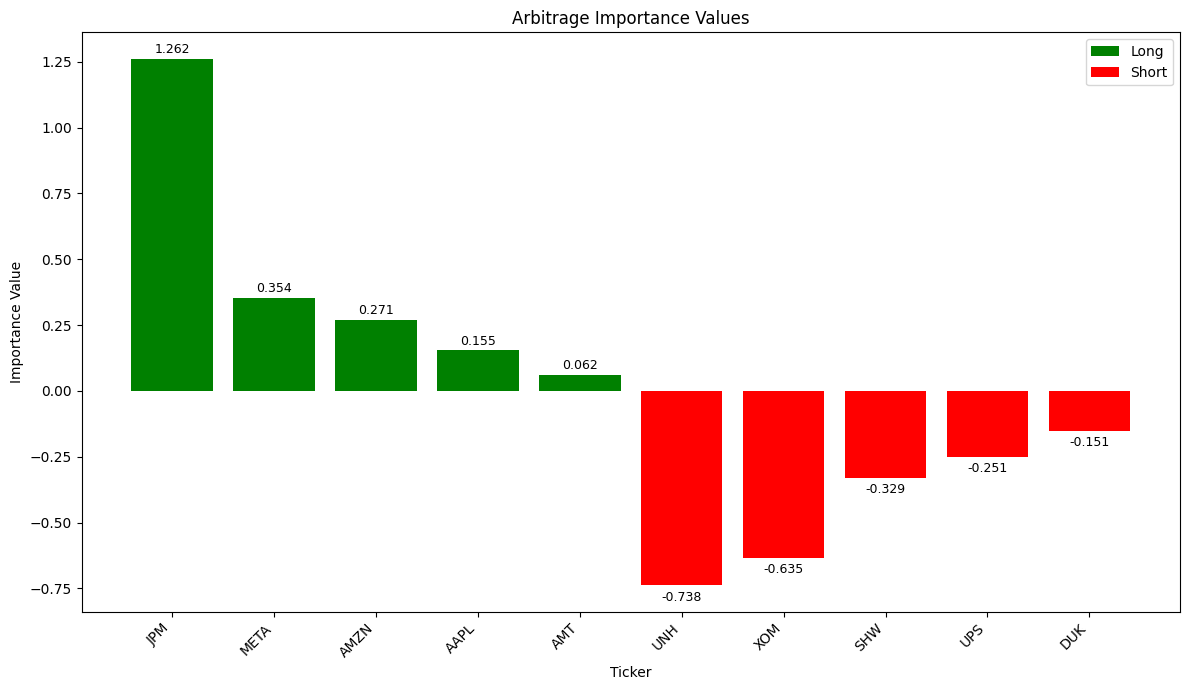

In [ ]:
# Plot the arbitrage importance values
plot_importance(arbitrage_ticker_to_importance, title='Arbitrage Importance Values')

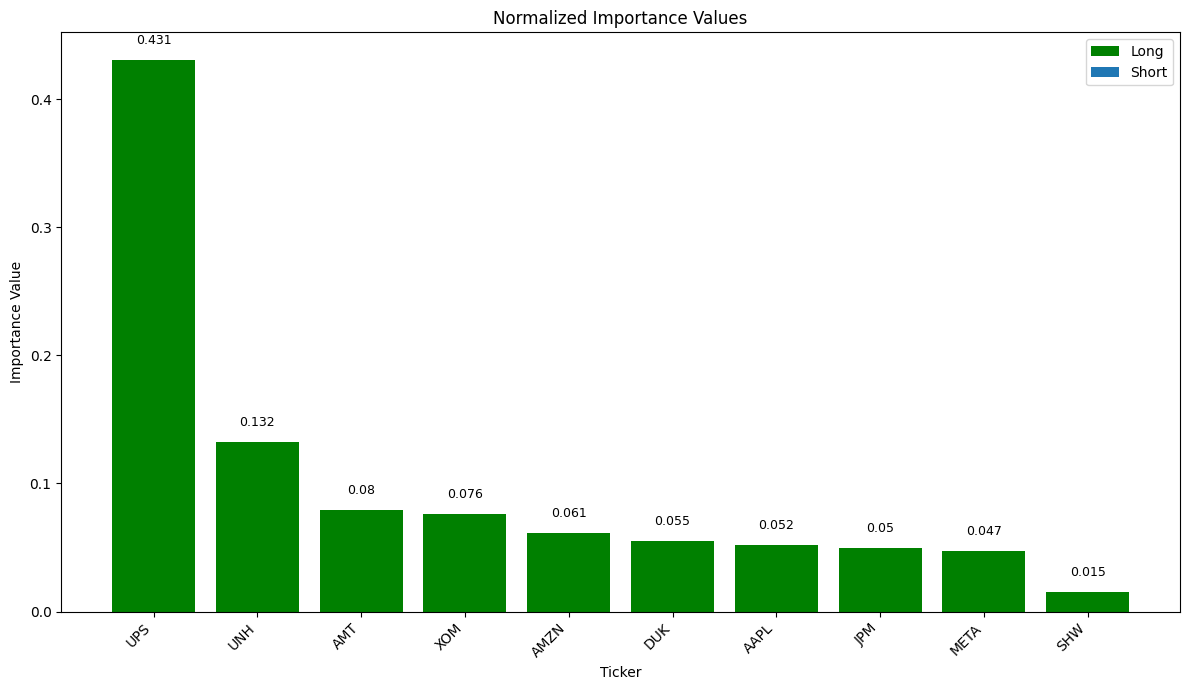

In [ ]:
# Plot the importance values
plot_importance(normalized_ticker_to_importance, title='Normalized Importance Values')

In [ ]:
spy_data = yf.download('SPY')
spy_monthly = spy_data.resample('M').last()
spy_monthly

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-31,43.968750,43.968750,43.750000,43.937500,24.941393,1003200
1993-02-28,44.437500,44.437500,44.187500,44.406250,25.207481,66200
1993-03-31,45.343750,45.468750,45.187500,45.187500,25.772116,111600
1993-04-30,44.125000,44.281250,44.031250,44.031250,25.112654,88500
1993-05-31,45.406250,45.406250,45.000000,45.218750,25.789925,79100
...,...,...,...,...,...,...
2023-06-30,441.440002,444.299988,441.109985,443.279999,441.721893,104921500
2023-07-31,457.410004,458.160004,456.049988,457.790009,456.180908,62040400
2023-08-31,451.649994,452.829987,450.160004,450.350006,448.767059,66084600


In [ ]:
all_data

{'XOM':           Date        Open        High         Low       Close   Adj Close  \
 0   1962-01-31    0.000000    1.656250    1.636719    1.656250    0.101445   
 1   1962-02-28    0.000000    1.757813    1.726563    1.730469    0.107163   
 2   1962-03-31    0.000000    1.710938    1.703125    1.707031    0.105711   
 3   1962-04-30    0.000000    1.710938    1.671875    1.671875    0.103534   
 4   1962-05-31    0.000000    1.632813    1.609375    1.625000    0.101744   
 ..         ...         ...         ...         ...         ...         ...   
 736 2023-05-31  102.290001  103.040001  101.739998  102.180000  101.349197   
 737 2023-06-30  107.320000  107.879997  106.809998  107.250000  106.377975   
 738 2023-07-31  105.190002  107.860001  105.190002  107.239998  106.368050   
 739 2023-08-31  111.120003  111.419998  110.620003  111.190002  111.190002   
 740 2023-09-30  117.550003  118.660004  117.320000  118.345001  118.345001   
 
        Volume  Sector Ticker  
 0     1718

In [ ]:
# Construct the Portfolio and Backtest
def build_portfolio(normalized_ticker_to_importance=normalized_ticker_to_importance, strategy='Normal'):
    portfolio_returns = pd.DataFrame()
    for ticker, importance in normalized_ticker_to_importance.items():
        data = all_data[ticker].set_index('Date')
        data['Returns'] = data['Adj Close'].pct_change().fillna(0)
        portfolio_returns[ticker] = data['Returns'] * importance
    portfolio_returns['Portfolio'] = portfolio_returns.sum(axis=1)
    spy_monthly['SPY Returns'] = spy_monthly['Adj Close'].pct_change().fillna(0)
    # Cumulative Returns
    portfolio_returns['Cumulative Portfolio'] = (portfolio_returns['Portfolio'] + 1).cumprod() - 1
    spy_monthly['Cumulative SPY'] = (spy_monthly['SPY Returns'] + 1).cumprod() - 1
    combined = pd.concat([portfolio_returns['Cumulative Portfolio'], spy_monthly['Cumulative SPY']], axis=1).dropna()
    print(combined)
    # Plot
    plt.figure(figsize=(14,7))
    combined['Cumulative Portfolio'].plot(label="Portfolio")
    combined['Cumulative SPY'].plot(label="SPY")
    plt.legend()
    plt.title(strategy + " Portfolio vs. SPY Cumulative Returns")
    plt.show()

            Cumulative Portfolio  Cumulative SPY
Date                                            
1993-03-31              0.775998        0.033307
1993-04-30              0.898116        0.006867
1993-06-30              0.591055        0.037751
1993-08-31              0.202733        0.072295
1993-09-30              0.041229        0.064493
...                          ...             ...
2023-03-31             -0.999088       15.295855
2023-05-31             -0.998953       15.632607
2023-06-30             -0.998970       16.710397
2023-07-31             -0.999027       17.290116
2023-08-31             -0.999012       16.992866

[259 rows x 2 columns]


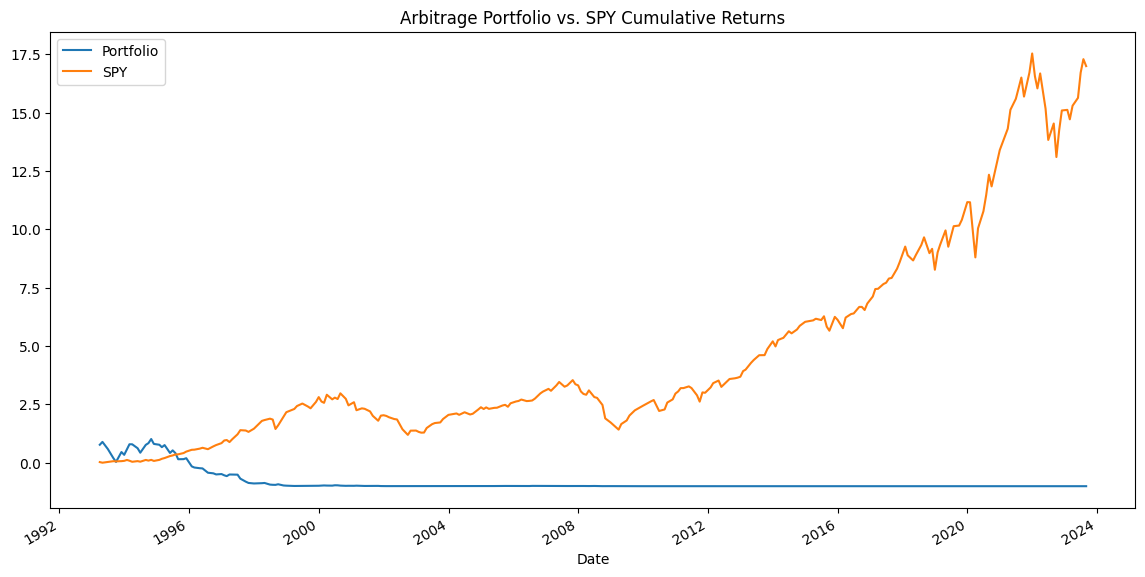

In [ ]:
# Build the portfolio for arbitrage strategy
build_portfolio(arbitrage_ticker_to_importance, strategy='Arbitrage')

            Cumulative Portfolio  Cumulative SPY
Date                                            
1993-01-31              2.822007        0.000000
1993-02-28              2.672757        0.010669
1993-03-31              2.764438        0.033307
1993-04-30              2.775301        0.006867
1993-05-31              2.850289        0.034021
...                          ...             ...
2023-05-31            177.729271       15.632605
2023-06-30            188.304466       16.710394
2023-07-31            195.803793       17.290114
2023-08-31            184.964442       16.992863
2023-09-30            183.258540       16.139380

[369 rows x 2 columns]


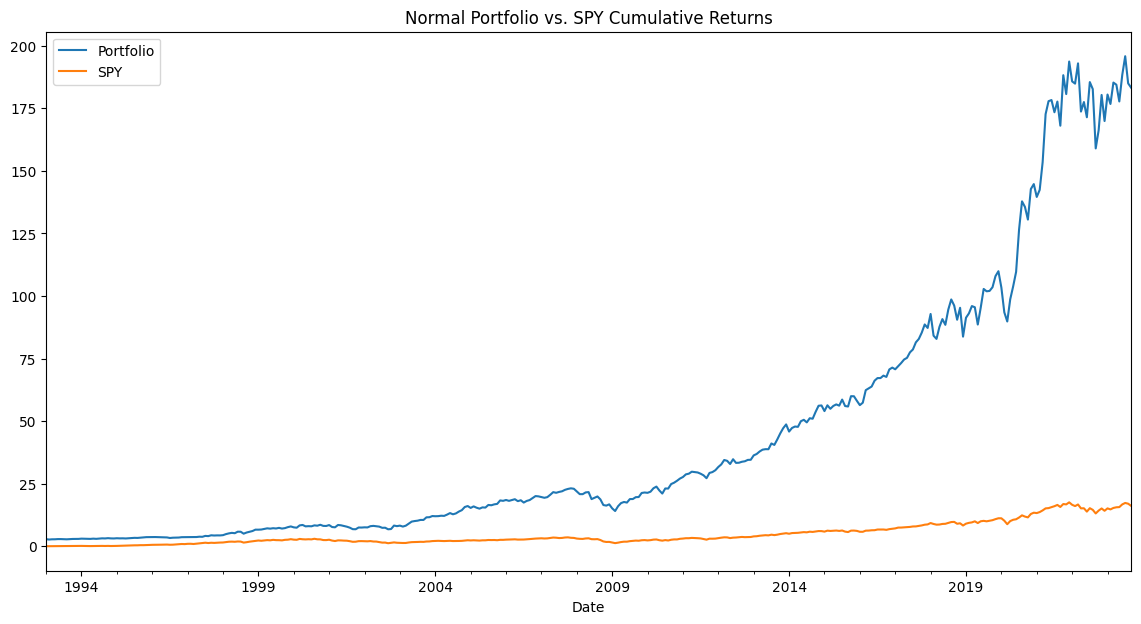

In [ ]:
# Build the portfolio for the Normal strategy
build_portfolio(normalized_ticker_to_importance, strategy='Normal')